In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os

rnd = 384
np.random.seed(rnd)
torch.manual_seed(rnd)

In [2]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/compas-scores-two-years.csv')
df = df[(df.days_b_screening_arrest>=-30)*(df.days_b_screening_arrest<=30)]
df = df.drop(['name','id','dob','age_cat','c_case_number','compas_screening_date','c_jail_in','c_jail_out','c_offense_date',
              'c_arrest_date','r_case_number','r_charge_degree','r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in',
              'r_jail_out','violent_recid','vr_case_number','vr_charge_degree','vr_offense_date','vr_charge_desc','v_screening_date',
              'in_custody','out_custody','v_type_of_assessment','type_of_assessment','screening_date','is_recid','first','last','c_charge_desc'],axis=1,inplace=False)
cat_columns = ['sex','race','c_charge_degree','score_text','v_score_text','event','is_violent_recid']
idx = np.ravel([np.where(np.array(list(df.columns)) == i) for i in cat_columns])
df = df.loc[:,cat_columns+list(np.delete(df.columns, idx))]
df.loc[:,'event'] = df.event.replace({0:'event_0',1:'event_1'})
df.loc[:,'is_violent_recid'] = df.is_violent_recid.replace({0:'not_violent_recid',1:'violent_recid'})
df.loc[:,'c_charge_degree'] = df.c_charge_degree.replace({'M':'charge_degree_M','F':'charge_degree_F'})
df.loc[:,'score_text'] = df.score_text.replace({'Low':'score_text_low','Medium':'score_text_medium','High':'score_text_high'})
df.loc[:,'v_score_text'] = df.v_score_text.replace({'Low':'v_score_text_low','Medium':'v_score_text_medium','High':'v_score_text_high'})
df = df[~df.duplicated()]
y = df["two_year_recid"].astype(int)
df = df.drop(['two_year_recid'],axis=1,inplace=False)

X = df.copy()
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,7:] = std.fit_transform(X.values[:,7:])
hot_enc = OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(X.iloc[:,:7])
X[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(X.iloc[:,:7]).toarray().astype(int)
X.drop(['sex','race','c_charge_degree','score_text','v_score_text','event','is_violent_recid'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [3]:
X_train

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
3335,-0.923077,-1.0,-0.333333,-1.0,-1.000000,-1.000000,-0.033333,-0.999789,-0.333333,0.111111,-1.000000,-1.000000,-0.811130,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0
287,-0.512821,-1.0,-1.000000,-1.0,-1.000000,-0.842105,-0.133333,-0.999157,-1.000000,-1.000000,-0.842105,-1.000000,0.278246,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
7162,-0.512821,-1.0,-0.555556,-1.0,-1.000000,-0.789474,-0.033333,-0.999789,-0.555556,-0.777778,-0.789474,-1.000000,0.851602,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3419,-0.871795,-1.0,-0.111111,-1.0,-1.000000,-0.947368,-0.066667,-0.999578,-0.111111,-0.111111,-0.947368,-1.000000,-0.809444,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0
4800,-0.692308,-1.0,-0.333333,-1.0,-0.777778,-0.894737,0.000000,-1.000000,-0.333333,-0.333333,-0.894737,-1.000000,-0.399663,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,-0.589744,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-0.100000,-0.999367,-1.000000,-0.777778,-1.000000,-1.000000,0.258010,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
181,-0.846154,-1.0,-0.777778,-1.0,-1.000000,-1.000000,-0.033333,-0.999789,-0.777778,-0.333333,-1.000000,-0.997866,0.362563,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0
4322,0.051282,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-0.033333,-0.999789,-1.000000,-1.000000,-1.000000,-1.000000,0.323777,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
2887,-0.256410,-1.0,-1.000000,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-1.000000,-1.000000,-0.947368,-0.997866,-0.205734,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1


### XGBOOST

In [3]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, use_label_encoder=False, eval_metric='logloss', random_state=rnd)
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./BlackBoxes/compas_xgboost.p','wb'))

clf_xgb = pickle.load(open('./BlackBoxes/compas_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

XGBOOST
train acc: 0.994935170178282
test acc: 0.9562753036437247


<AxesSubplot:>

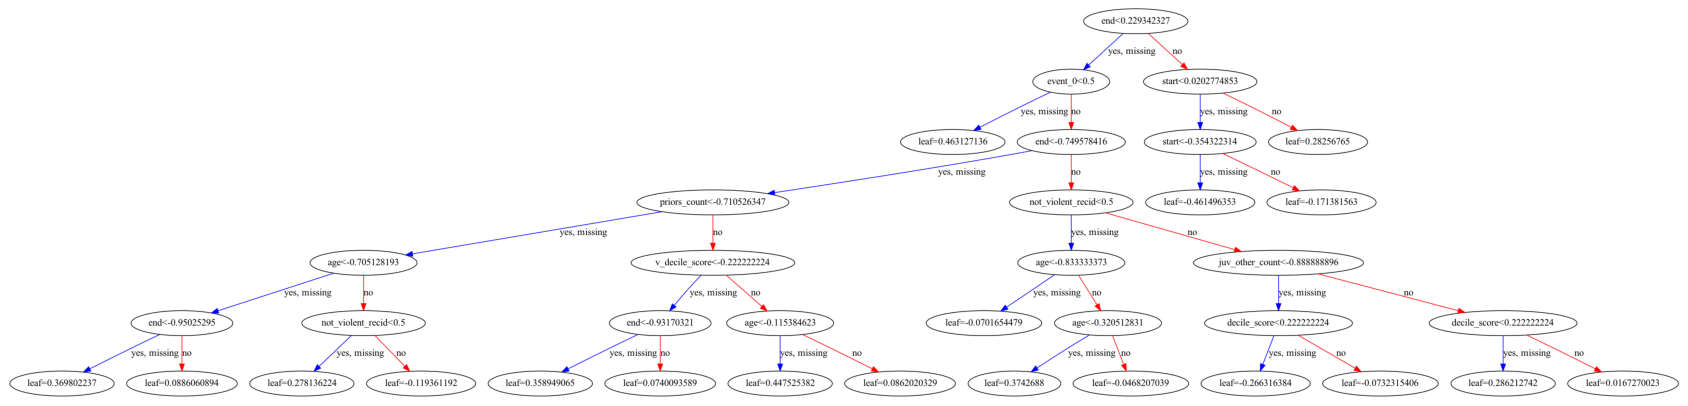

In [4]:
from xgboost import plot_tree

plt.figure(figsize=(30,10))
plot_tree(clf_xgb,num_trees=1,ax=plt.gca())

### RF

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=12,random_state=rnd)
clf_rf.fit(X_train, y_train)

pickle.dump(clf_rf,open('./BlackBoxes/compas_rf.p','wb'))
clf_rf

RandomForestClassifier(max_depth=12, random_state=384)

In [6]:
clf_rf = pickle.load(open('./BlackBoxes/compas_rf.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()

y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.9837925445705025
test acc: 0.965991902834008


### SVC

In [7]:
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
pickle.dump(clf_svc,open('./BlackBoxes/compas_svc.p','wb'))

clf_svc = pickle.load(open('./BlackBoxes/compas_svc.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()

y_train_pred = predict(X_train, return_proba=True)
y_test_pred = predict(X_test, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

SVC
train acc: 0.9333468395461912
test acc: 0.9441295546558705


### NN

2022-04-06 14:21:54.680572: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 14:21:54.682152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:258] None of the MLIR optimization passes are enabled (registered 0 passes)
/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2366: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


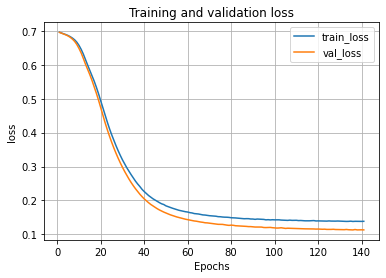

NN
0.9313209076175041
0.9449392712550607
---------------


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

early_stopping = EarlyStopping(patience=5)

clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0
    )

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/compas_tf_nn')

from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/compas_tf_nn')
clf_nn.trainable = False

def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()

print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))
print('---------------')

In [9]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

In [10]:
X_train.shape

(4936, 33)

# Latent Space

In [12]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [205]:
latent_dim = 10
alpha = 1.5
batch_size = 2048
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3
idx_cat = list(range(13,33,1))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = torch.cdist(Z,Z)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, alpha, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = torch.cdist(X_cont,X_cont)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + alpha * D_class
    else:
        D = torch.cdist(X,X) + alpha * D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, alpha, idx_cat)
    Sz = compute_similarity_Z(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [125]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_compas.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_compas.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/compas_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [206]:
model.load_state_dict(torch.load(f'./models/compas_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

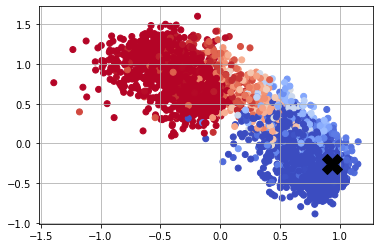

In [207]:
idx = 0
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
plt.grid()

In [208]:
idx = 0
predict(X_test[idx:idx+1,:-1],return_proba=True)

array([0.00038], dtype=float32)

In [209]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

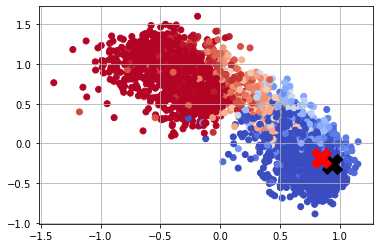

In [210]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = +0.1
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'rX', markersize=20)
plt.quiver(Z_test[idx,0], Z_test[idx,1], m*y_contrib[0],m*y_contrib[1], angles='xy', scale_units='xy', scale=1, color='m')
plt.grid()

### Counterfactual Explanation

In [211]:
q = X_test[0].copy()
predict(q[:-1].reshape(1,-1),return_proba=True)

array([0.00038], dtype=float32)

In [212]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
w.shape

(10, 34)

In [213]:
def compute_cf(q, indexes, max_iter=500):
    it = 0
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        q_cf[indexes] += delta_i
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
        it += 1
        if it == max_iter:
            return q_cf
    return q_cf

In [214]:
idx = 0
q = X_test[idx,:].copy()
print(predict(q[:-1].reshape(1,-1),return_proba=True))


[0.00038]


In [215]:
from itertools import combinations

q = X_test[idx,:].copy()
pred = int(predict(q[:-1].reshape(1,-1)))
q_cfs = []
l_i = []
l_f = []

for indexes in  list(combinations(list(range(34)),1)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
    if pred:
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
    else:
        if q_cf_pred>0.5:
            q_cfs.append(q_cf) 

for indexes in  list(combinations(list(range(34)),2)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
    if pred:
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
    else:
        if q_cf_pred>0.5:
            q_cfs.append(q_cf)
    l_i.append([list(indexes),q_cf_pred])
r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
l_i = np.array(l_i,dtype=object)[r,0]

while len(l_i[0])<6:
    for e in l_i:
        for i in list(np.delete(range(34),e)):
            q_cf = compute_cf(q, e+[i])
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf)
            l_f.append([e+[i],q_cf_pred])
    r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
    l_f = np.array(l_f,dtype=object)[r,0]
    l_i = l_f.copy()
    l_f = []

q_cfs = np.vstack(q_cfs)

In [216]:
q_cfs.shape

(694, 34)

In [217]:
from scipy.spatial.distance import cdist, euclidean

print('d_dist: ', np.min(cdist(q_cfs[:,13:-1],q[13:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:13],q[:13].reshape(1,-1),metric='euclidean')))
print('d_count: ', np.min(np.sum(q_cfs[:,:-1]!=q[:-1],axis=1)))
print('d_impl: ',np.min(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean')))
r = np.argsort(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
print('d_adv: ', np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(q_cfs.shape[0])])))

d_dist:  0.6987814639205783
d_count:  2
d_impl:  0.18423695566625875
d_adv:  0.5871757925072046


In [218]:
from itertools import combinations
from tqdm.notebook import tqdm

d_dist = []
d_count = []
d_impl = []
d_adv = []

for idx in tqdm(range(10)):
    q = X_test[idx,:].copy()
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
    q_cfs = []
    l_i = []
    l_f = []

    for indexes in  list(combinations(list(range(34)),1)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 

    for indexes in  list(combinations(list(range(34)),2)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 
        l_i.append([list(indexes),q_cf_pred])
    r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
    l_i = np.array(l_i,dtype=object)[r,0]

    while len(l_i[0])<6:
        for e in l_i:
            for i in list(np.delete(range(34),e)):
                q_cf = compute_cf(q, e+[i])
                q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                if q_pred:
                    if q_cf_pred<0.5:
                        q_cfs.append(q_cf)
                else:
                    if q_cf_pred>0.5:
                        q_cfs.append(q_cf) 
                l_f.append([e+[i],q_cf_pred])
        r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
        l_f = np.array(l_f,dtype=object)[r,0]
        l_i = l_f.copy()
        l_f = []
    
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)
        d_dist.append(np.min(cdist(q_cfs[:,13:-1],q[13:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:13],q[:13].reshape(1,-1),metric='euclidean')))
        d_count.append(np.min(np.sum(q_cfs[:,:-1]!=q[:-1],axis=1)))
        d_impl.append(np.min(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean')))
        r = np.argsort(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
        d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))

  0%|          | 0/10 [00:00<?, ?it/s]

In [219]:
print('d_dist: ',np.mean(np.array(d_dist)))
print('d_count: ',np.mean(np.array(d_count)))
print('d_impl: ',np.mean(np.array(d_impl)))
print('d_adv: ',np.mean(np.array(d_adv)))

d_dist:  0.5184364073046606
d_count:  1.3
d_impl:  0.3077058298427063
d_adv:  0.388311808454712


In [220]:
len(d_dist)

10

# Watcher

In [188]:
from scipy.spatial.distance import cdist, euclidean, hamming
from scipy.optimize import minimize
from scipy import stats

# initial conditions
lamda = 0.1 
x0 = np.zeros([1,X_train.shape[1]-1]) # initial guess for cf
q = X_test[0:1,:-1]
pred = predict(q,return_proba=False)
print('pred: ', pred)

def dist_mad(cf, eg):
    manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
    mad = stats.median_abs_deviation(X_train[:,:-1])
    mad[mad == 0] = 1
    return sum(manhat)

def loss_function_mad(x_dash):
    target = 1-pred
    if target == 0:
        L = lamda*(predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q)
    else:
        L = lamda*(1-predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q) 
    return L

res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
cf = res.x.reshape(1, -1)
cf[:,13:] = np.ceil(cf[:,13:])

i=0
while pred == predict(cf,return_proba=False):
    lamda += 0.1
    x0 = cf 
    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
    cf = res.x.reshape(1, -1)
    cf[:,13:] = np.ceil(cf[:,13:])
    i += 1
    if i == 100:
        print('Error condition not met after',i,'iterations')
        break

pred:  [0]


In [193]:
d_dist_watch = []
d_count_watch = []
d_impl_watch = []
d_adv_watch = []

for i in tqdm(range(10)):
    # initial conditions
    lamda = 0.1 
    x0 = np.zeros([1,X_train.shape[1]-1]) # initial guess for cf
    q = X_test[i:i+1,:-1]
    pred = predict(q,return_proba=False)

    def dist_mad(cf, eg):
        manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
        #mad = stats.median_abs_deviation(X_train)
        #mad[mad == 0] = 1
        return sum(manhat)

    def loss_function_mad(x_dash):
        target = 1-pred
        if target == 0:
            L = lamda*(predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q)
        else:
            L = lamda*(1-predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q) 
        return L

    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
    cf = res.x.reshape(1, -1)
    cf[:,13:] = np.ceil(cf[:,13:])

    i=0
    while pred == predict(cf,return_proba=False):
        lamda += 0.1
        x0 = cf 
        res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
        cf = res.x.reshape(1, -1)
        cf[:,13:] = np.ceil(cf[:,13:])
        i += 1
        if i == 100:
            break

    if pred != predict(cf,return_proba=False):
        d_dist_watch.append(float(hamming(cf[:,13:].ravel(),q[:,13:].ravel()) + euclidean(cf[:,:13].ravel(),q[:,:13].ravel())))
        d_count_watch.append(np.sum(cf!=q))
        d_impl_watch.append(np.min(cdist(cf[:,13:].reshape(1,-1),X_train[:,13:-1],metric='hamming') + cdist(cf[:,:13].reshape(1,-1),X_train[:,:13],metric='euclidean')))
        r = np.argsort(cdist(cf[:,13:],X_train[:,13:-1],metric='hamming') + cdist(cf[:,:13],X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
        d_adv_watch.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(cf.shape[0])])))

  0%|          | 0/10 [00:00<?, ?it/s]

In [195]:
print('d_dist: \t',    np.round(np.mean(d_dist_watch),5),   np.round(np.std(d_dist_watch),5))
print('d_count: \t',   np.round(np.mean(d_count_watch),5),  np.round(np.std(d_count_watch),5))
print('implicity: \t', np.round(np.mean(d_impl_watch),5),   np.round(np.std(d_impl_watch),5))
print('d_adv: \t \t', np.round(np.mean(d_adv_watch),5),   np.round(np.std(d_adv_watch),5))

d_dist: 	 3.38842 0.2321
d_count: 	 22.16667 1.21335
implicity: 	 2.4355 0.07327
d_adv: 	 	 0.18333 0.10672


# Growing Spheres

In [196]:
from growingspheres import counterfactuals as cf

idx = 0
q = X_test[idx,:-1].reshape(1,-1).copy()
pred = int(predict(q))
print('pred: ', pred)

CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy
print(predict(q_cf_GS.reshape(1,-1)))

pred:  0
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  60
Final radius:  (1.0720000000000005, 1.0900000000000005)
Final number of ennemies:  1
Feature selection...
Reduced 29 coordinates
[1]


In [197]:
pd.DataFrame(np.vstack([q,q_cf_GS.reshape(1,-1)]), columns = X.columns)

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
0,-0.820513,-1.0,-0.777778,-1.0,-1.0,-1.0,0.0,-0.999789,-0.777778,-0.555556,-1.0,-1.000000,0.780776,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0
1,-0.920702,-1.0,-0.777778,-1.0,-1.0,-1.0,0.0,-0.999789,-0.777778,-0.555556,-1.0,-0.734723,0.358711,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.450482,0.0,1.0,0.0


In [199]:
from scipy.spatial.distance import cdist, euclidean

print('d_dist: ', float(cdist(q_cf_GS[13:].reshape(1,-1),q[:,13:],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),q[:,:13],metric='euclidean')))
print('d_count: ', int(np.sum(q_cf_GS!=q,axis=1)))
print('d_impl: ', np.min(cdist(q_cf_GS[13:].reshape(1,-1),X_train[:,13:-1],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),X_train[:,:13],metric='euclidean')))
r = np.argsort(cdist(q_cf_GS[13:].reshape(1,-1),X_train[:,13:-1],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
print('d_adv: ', np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(q_cf_GS.reshape(1,-1).shape[0])])))

d_dist:  0.5584768806937596
d_count:  4
d_impl:  0.34954767819924276
d_adv:  1.0


In [200]:
d_dist_GS = []
d_count_GS = []
d_impl_GS = []
d_adv_GS = []

for idx in tqdm(range(10)):
    q = X_test[idx,:-1].reshape(1,-1).copy()
    pred = int(predict(q))
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
    q_cf_GS = CF.enemy
    d_dist_GS.append(float(cdist(q_cf_GS[13:].reshape(1,-1),q[:,13:],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),q[:,:13],metric='euclidean')))
    d_count_GS.append(int(np.sum(q_cf_GS!=q,axis=1)))
    d_impl_GS.append(np.min(cdist(q_cf_GS[13:].reshape(1,-1),X_train[:,13:-1],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),X_train[:,:13],metric='euclidean')))
    r = np.argsort(cdist(q_cf_GS[13:].reshape(1,-1),X_train[:,13:-1],metric='hamming') + cdist(q_cf_GS[:13].reshape(1,-1),X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
    d_adv_GS.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(q_cf_GS.reshape(1,-1).shape[0])])))

  0%|          | 0/10 [00:00<?, ?it/s]

In [203]:
print('d_dist_GS: ',np.mean(np.array(d_dist_GS)))
print('d_count_GS: ', np.mean(np.array(d_count_GS)))
print('d_impl_GS: ',np.mean(np.array(d_impl_GS)))
print('d_adv: ', np.round(np.mean(d_adv_GS),5),   np.round(np.std(d_adv_GS),5))

d_dist_GS:  0.407651236744894
d_count_GS:  2.8
d_impl_GS:  0.43526640714115244
d_adv:  0.84 0.16248


In [204]:
len(d_dist_GS)

10

In [222]:
X_train.shape

(4936, 34)

# DICE

In [221]:
import dice_ml

dataset = pd.concat((X_train,y_train),axis=1)
d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hoursPerWeek'], outcome_name='income')

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [11]:
m = dice_ml.Model(model=clf_rf, backend='sklearn')

In [12]:
# initiate DiCE
exp_random = dice_ml.Dice(d, m, method='random')

In [13]:
dataset

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services,income
46220,0.342466,0.000000,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
15910,-0.534247,0.612245,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2746,-0.726027,-0.367347,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
40636,-0.424658,0.204082,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
6931,-0.041096,0.693878,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39461,-0.561644,-0.102041,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0
16951,-0.150685,-0.204082,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0
28487,-0.123288,0.000000,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
11005,-0.671233,-0.204082,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


In [14]:
query_instances = dataset.iloc[0:1,:-1]

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, 
                                                      total_CFs=1, 
                                                      desired_class="opposite", 
                                                      verbose=True,
                                                      permitted_range={'age':[-1, 1], 'hoursPerWeek':[-1, 1]})

#dice_exp_random.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec
